# Sparkline Training - GA Exercise

This exercise contains example data from the Google Merchandise Store via the Google Analytics Demo Account, as well as some fabricated cost price data for practice purposes.

## Overview
### Datasets
- Transaction data from 2017-04 to 2017-06 available in multiple files split by month (transactions_*.csv)
    - Each purchase on the Google Merchandise Store is logged as a transaction with a unique Transaction ID.
    - Each transaction can be comprised of one or more Product SKUs, with varying quantities.
    - Avg. Price refers to the price of each product unit that was sold within that transaction.
    
    
- Cost price data from 2017-04 to 2017-06 available in a single file (cost_price_2017-04_2017-06.csv)
    - The accounting department provides a monthly record of the average cost price of a product unit per SKU.

### Task
- Generate Top 20 Product Categories with the largest profit margin
- Generate Top 20 SKUs with the largest profit margin
- Plot the number of units sold over time for the Top 20 SKUs
    - Horizontal line charts - one SKU per subplot
    - X Axis: date, Y axis: quantity of units sold
   
### Other Requirements
- Datatype conversion whenever appropriate
- Rename original columns to a standardized format
    - **Date** => date
    - **Transaction ID** => transaction_id
    - **Product SKU** => sku
    - **Product** => product_name
    - **Product Category (Enhanced Ecommerce)** => product_category
    - **Quantity** => quantity
    - **Avg. Price** => price
- Explore and validate data to confirm any assumptions to be made about the data
    - Why is there a need for SKUs? Wouldn't Product be enough to uniquely identify a product?
    - Is every SKU only mapped to a single category? If an individual SKU can be mapped to multiple categories, would that result in double-counting when aggregating?

### Importing and configuring libraries

In [35]:
import os
from datetime import datetime
import pandas as pd
from matplotlib import pyplot as plt

from pprint import pprint

# set pandas options to display all columns, or else columns would be displayed on multiple lines
pd.set_option('display.expand_frame_repr', False)

# define plotting library style
plt.style.use('ggplot')

### Setting up paths and folders

In [36]:
# identify the current directory
CURRENT_DIR = os.getcwd()

# NOTE: if run as a script via command line, os.getcwd() is not recommended. use the code below instead
# CURRENT_DIR = os.path.dirname(os.path.realpath(__file__))

# define the path of the directory where data would be read from, which is in {CURRENT_DIR}/data
READ_DIR = os.path.join(CURRENT_DIR, 'data')

# define the path of the directory where any potential files would be written to, which is in {CURRENT_DIR}/output
WRITE_DIR = os.path.join(CURRENT_DIR, 'output')

# checks if WRITE_DIR exists. create if it doesn't already exist
if not os.path.exists(WRITE_DIR):
    os.mkdir(WRITE_DIR)

### Define helper functions if needed

In [37]:
# convert text string ("$x,xxx.xx") to float
def currency_to_float(input_value):
    return float(input_value.lstrip('$').replace(',', ''))

# convert datetime object to "<year>-<month>"
def datetime_to_year_month(input_value):
    return input_value.strftime('%Y-%m')

def date_parser(date_string):
    return datetime.strptime(date_string, '%Y%m%d')

### Define and read files

Data is split into multiple files. The analysis should be done across all data in the separate files.

For this example, the structure of the data within these files can be assumed to be the same.

In [38]:
# define variable to store the collated Dataframe
transactions_df = None

# list files in folder
file_list = os.listdir(READ_DIR)

for file_name in file_list:
    if file_name.startswith('transactions_') and file_name.endswith('.csv'):
        read_path = os.path.join(READ_DIR, file_name)

        df = pd.read_csv(
            read_path,
            parse_dates=['Date'],
            date_parser=date_parser,
            thousands=','
        )

        if transactions_df is None:
            transactions_df = df
        else:
            transactions_df = transactions_df.append(df, ignore_index=True)

### Rename Columns

- **Date** => date
- **Transaction ID** => transaction_id
- **Product SKU** => sku
- **Product** => product_name
- **Product Category (Enhanced Ecommerce)** => product_category
- **Quantity** => quantity
- **Avg. Price** => price

In [39]:
renaming_map = {
    'Date': 'date',
    'Transaction ID': 'transaction_id',
    'Product SKU': 'sku',
    'Product': 'product_name',
    'Product Category (Enhanced Ecommerce)': 'product_category',
    'Quantity': 'quantity',
    'Avg. Price': 'price'
}

transactions_df = transactions_df.rename(columns=renaming_map)

### Modify data
- Convert **price** to float
- Add new column **year_month** derived from **date**

In [40]:
# convert price string to float
transactions_df['price'] = transactions_df['price'].apply(currency_to_float)

# add new column with year_month
transactions_df['year_month'] = transactions_df['date'].apply(datetime_to_year_month)

### Import cost data

In [41]:
cost_path = os.path.join(READ_DIR, 'cost_price_2017-04_2017-06.csv')
cost_df = pd.read_csv(cost_path)

### Match cost price data for each sku for specific months

In [42]:
transactions_df = pd.merge(transactions_df, cost_df, how='left', on=['year_month', 'sku'])

## Get Top 20 Product Categories with the highest profit margin

### Approach 1: Group then calculate profit margin

In [43]:
# group data by product_category
category_profit_margin_df = transactions_df.groupby(['product_category'], as_index=False).agg(
    {
        'price': pd.np.mean,
        'cost_price': pd.np.mean,
        'quantity': pd.np.sum
    }
)

# calculate average profit margins
category_profit_margin_df['avg_profit_margin'] = category_profit_margin_df.apply(lambda row: round((row['price'] - row['cost_price']) / row['price'] * 100, 2), axis=1)

# filter for only the necessary columns
category_profit_margin_df = category_profit_margin_df[['product_category', 'avg_profit_margin', 'quantity']]

# sort data by avg_profit_margin descending and product_name ascending
category_profit_margin_df = category_profit_margin_df.sort_values('avg_profit_margin', ascending=False)

# reset index for cosmetic reasons
category_profit_margin_df = category_profit_margin_df.reset_index(drop=True)

# filter only the top 20 results
category_profit_margin_df = category_profit_margin_df.head(20)

# write result as csv
write_path = os.path.join(WRITE_DIR, 'category_profit_margin_1.csv')
category_profit_margin_df.to_csv(write_path, index=False)

print(category_profit_margin_df)

                      product_category  avg_profit_margin  quantity
0                               Google              60.02       175
1                              Bottles              58.76       613
2                           Gift Cards              57.98        77
3                                  Fun              57.74       433
4                          Nest-Canada              54.99       135
5                             Headgear              54.65       940
6                               Office              52.65     29105
7                             Nest-USA              52.63      5258
8                            More Bags              52.02        37
9                                 Waze              51.95       383
10                           Lifestyle              51.73      6884
11                             Apparel              51.48      9416
12                           Backpacks              50.98        44
13  ${productitem.product.origCatName}          

### Approach 2: Calculate profit margin then group

In [44]:
# make a copy of transactions_df to prevent changing the original object
category_profit_margin_df = transactions_df.copy()

# calculate average profit margins
category_profit_margin_df['profit_margin'] = category_profit_margin_df.apply(lambda row: (row['price'] - row['cost_price']) / row['price'] * 100, axis=1)

# group data by product_category
category_profit_margin_df = category_profit_margin_df.groupby(['product_category'], as_index=False).agg(
    {
        'profit_margin': lambda x: pd.np.round(pd.np.mean(x), 2),
        'quantity': pd.np.sum
    }
)

# rename column
category_profit_margin_df = category_profit_margin_df.rename(columns={'profit_margin': 'avg_profit_margin'})

# sort data by avg_profit_margin descending and product_name ascending
category_profit_margin_df = category_profit_margin_df.sort_values('avg_profit_margin', ascending=False)

# reset index for cosmetic reasons
category_profit_margin_df = category_profit_margin_df.reset_index(drop=True)

# filter only the top 20 results
category_profit_margin_df = category_profit_margin_df.head(20)

# write result as csv
write_path = os.path.join(WRITE_DIR, 'category_profit_margin_2.csv')
category_profit_margin_df.to_csv(write_path, index=False)

print(category_profit_margin_df)

                      product_category  avg_profit_margin  quantity
0                               Google              59.82       175
1                           Gift Cards              58.05        77
2                              Bottles              57.86       613
3                                  Fun              57.43       433
4                          Nest-Canada              54.80       135
5                             Headgear              53.86       940
6                            Backpacks              52.91        44
7   ${productitem.product.origCatName}              52.08       990
8                                 Waze              52.00       383
9                               Office              51.99     29105
10                           More Bags              51.90        37
11                           Lifestyle              51.69      6884
12                            Nest-USA              51.61      5258
13                             Apparel          

## Get Top 20 SKUs with the highest profit margin
### Validate data
- Confirm the assumption that each SKU has only one product name
- If not, when grouping, data would be incorrect

In [45]:
# get df of unique combinations of sku and product_name
check_df = transactions_df[['sku', 'product_name']].drop_duplicates()

# count the number of product_name associated with each sku
check_df = check_df.groupby('sku', as_index=False).agg({'product_name': 'count'})

# halt programme if any discrepancies are found
assert check_df[check_df['product_name'] > 1].empty, 'SKUs with same id but different product names found'

In [46]:
# group data by sku as well as product_name
sku_profit_margin_df = transactions_df.groupby(['sku', 'product_name'], as_index=False).agg(
    {
        'price': pd.np.mean,
        'cost_price': pd.np.mean,
        'quantity': pd.np.sum
    }
)

# calculate average profit margins
sku_profit_margin_df['avg_profit_margin'] = sku_profit_margin_df.apply(lambda row: round((row['price'] - row['cost_price']) / row['price'] * 100, 2), axis=1)

# filter for only the necessary columns
sku_profit_margin_df = sku_profit_margin_df[['sku', 'product_name', 'avg_profit_margin', 'quantity']]

# sort data by avg_profit_margin descending and product_name ascending
sku_profit_margin_df = sku_profit_margin_df.sort_values(['avg_profit_margin', 'product_name'], ascending=[False, True])

# set minimum requirement for quantity
sku_profit_margin_df = sku_profit_margin_df[sku_profit_margin_df['quantity'] >= 500]

# reset index for cosmetic reasons
sku_profit_margin_df = sku_profit_margin_df.reset_index(drop=True)

# filter only the top 20 results
sku_profit_margin_df = sku_profit_margin_df.head(20)

# write result as csv
write_path = os.path.join(WRITE_DIR, 'sku_profit_margin.csv')
sku_profit_margin_df.to_csv(write_path, index=False)

print(sku_profit_margin_df)

               sku                                       product_name  avg_profit_margin  quantity
0   GGOEGFSR022099                                   Google Kick Ball              60.21      1519
1   GGOEGHGH019699                                  Google Sunglasses              60.09      1480
2   GGOEGDHC074099           Google 17oz Stainless Steel Sport Bottle              60.01       660
3   GGOEGHGR019499                                  Google Sunglasses              60.01       670
4   GGOEGOLC014299                       Google Metallic Notebook Set              60.00      1295
5   GGOENEBJ079499  Nestå¨ Learning Thermostat 3rd Gen-USA - Stain...              59.99      1003
6   GGOEGBJC019999                           Collapsible Shopping Bag              59.97       988
7   GGOEGFKA022299                               Keyboard DOT Sticker              59.67       805
8   GGOEGOCC017599                         Recycled Paper Journal Set              57.72       973
9   GGOEGF

## Plot units sold over time for the Top 20 SKUs
- Horizontal line charts - one SKU per subplot
- X Axis: date, Y axis: quantity of units sold

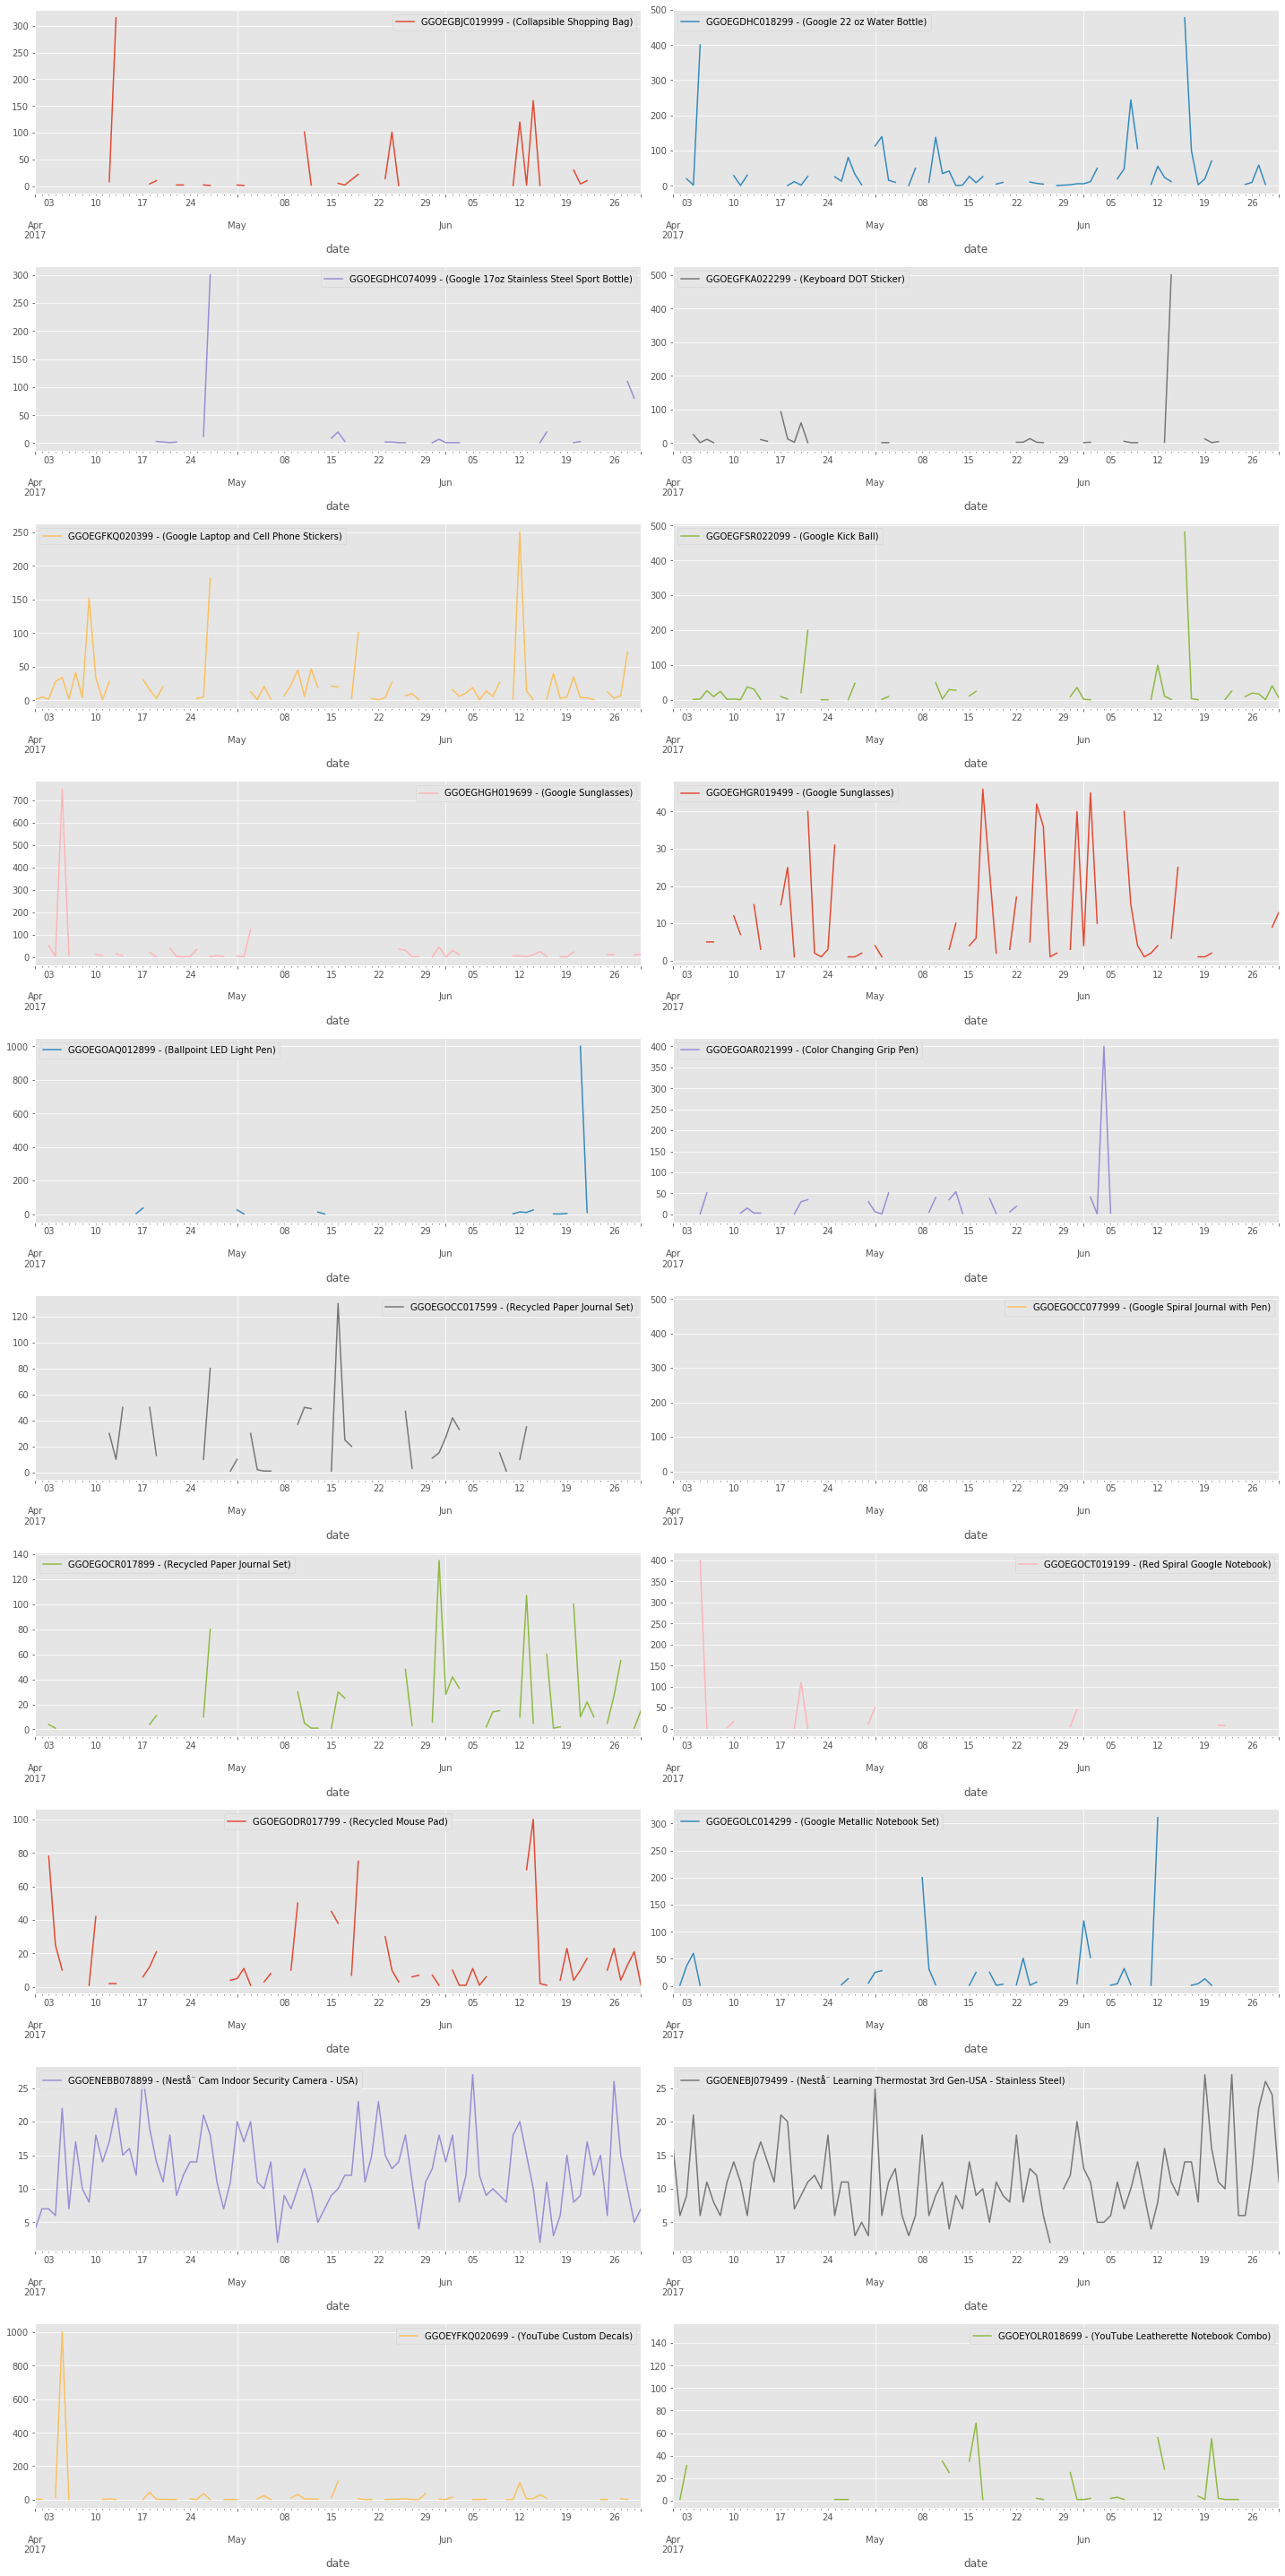

In [21]:
# filter transactions_df for skus in sku_profit_margin_df
# make a copy as slicing the dataframe still would operate on the original dataframe object
sku_df = transactions_df[transactions_df['sku'].isin(sku_profit_margin_df['sku'])].copy()

# modify with formatted name <sku> - (<product_name>)
sku_df['sku'] = sku_df.apply(lambda row: '%s - (%s)' % (row['sku'], row['product_name']), axis=1)

# group by date, sku then aggregate sum of quantity
sku_df = sku_df.groupby(['date', 'sku'], as_index=False).agg({'quantity': pd.np.sum})

# pivot data for plotting
sku_df = sku_df.pivot(index='date', columns='sku', values='quantity')

# plot dataframe with options (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.plot.html)
# subplots=True splits each line into individual graphs (subplots)
# sharex=False ensures each graph has its own x axis
# figsize=(20, 40) sets the size of the overall chart area (20 inches wide by 40 inches high)
# layout=(10, 2) sets the subplot layout to 10 rows of 2 columns

sku_df.plot(
    subplots=True, 
    sharex=False, 
    figsize=(20, 40), 
    layout=(10, 2), 
    kind='line'
)

# define location of the legend
plt.legend(loc='upper right')
plt.tight_layout(pad=1)

# export graph as image
write_path = os.path.join(WRITE_DIR, 'top_20_skus_sales_quantity.png')
plt.savefig(write_path)

plt.show()

## Advanced Validation
Ensure that all SKUs are mapped to exactly one product category

In [23]:
# 1a. get unique values of sku + product_category combination
category_sku_df = transactions_df[['sku', 'product_category']].drop_duplicates()

# 1b. count the number of categories associated with each sku
# 1b. concatenate the categories into string to gain some insight
category_sku_df = category_sku_df.groupby('sku', as_index=False)['product_category'].agg(
    {
        'count': 'count',
        'concat': lambda x: ','.join(x.sort_values())
    }
)

# 1c. filter for skus with more than 1 count (multiple categories associated with an sku)
repeated_sku_df = category_sku_df[category_sku_df['count'] > 1]
repeated_sku_df = repeated_sku_df.sort_values('count', ascending=False)
# print(repeated_sku_df)
# print()

# when querying for data, just get the relevant columns
col_subset = ['sku', 'date', 'transaction_id', 'product_category', 'quantity', 'price', 'cost_price']

# 1d. visual check if the entries are entire duplicates
check_repeated_sku_df = transactions_df[transactions_df['sku'].isin(repeated_sku_df.iloc[0:1]['sku'])]
check_repeated_sku_df = check_repeated_sku_df[col_subset].sort_values(['sku', 'transaction_id'])
# print(check_repeated_sku_df)
# print()

# 2. ensure that ${productitem.product.origCatName} is the only category that is being repeated
# concat string does NOT contain the flagged category AND count > 1
check_other_df = category_sku_df[
    (~category_sku_df['concat'].str.contains('${productitem.product.origCatName}', regex=False)) & 
    (category_sku_df['count'] > 1)
]
# print(check_other_df)
# print()

# 3a. check if there are skus that only have ${productitem.product.origCatName}
# concat string contains the flagged category AND count is 1 (unknown category) or count is more than 2 (multiple repeats)
dirty_df = category_sku_df[
    (category_sku_df['concat'].str.contains('${productitem.product.origCatName}', regex=False)) & 
    (category_sku_df['count'] != 2)
]
# print(dirty_df)
# print()

# 3b. assess impact of these skus on the rest of the metrics
check_dirty_df = transactions_df[transactions_df['sku'].isin(dirty_df['sku'])]
check_dirty_df = check_dirty_df[col_subset].sort_values(['sku', 'transaction_id'])
# print(check_dirty_df)
# print()